In [ ]:
!pip install transformers pandas google.colab

     |████████████████████████████████| 675kB 4.7MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 1.1MB 16.6MB/s 
     |████████████████████████████████| 890kB 32.4MB/s 
     |████████████████████████████████| 3.8MB 46.6MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 112kB 63.9MB/s 
  Created wheel for google.colab: filename=google_colab-1.0.0-py2.py3-none-any.whl size=102289 sha256=5a467c592940b7fb9565fa2baeaad89d6329a4f9cd61aeae46e965fc71db06e3
  Stored in directory: /root/.cache/pip/wheels/38/0d/59/701e300a337b2a2e07b27fe74dbfff0bc56ac58f711566ee67
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4714b31b451c6dc67f609d01e64f2c896f4c9624798f06386e43abfbfc542bae
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for portpicker: filename=portpicker-1.2.0-cp36-none-an

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/gdrive')

pd.set_option('display.max_colwidth', -1)

spreadsheet_name = ['huel_forum_posts',
                    'bnz_forum_posts',
                    'airline_forum_updated',
                    'quickfile_forum_posts',
                    'codecombat_forum_posts',
                    'schizophrenia_forum_posts',
                    'folksy_forum_posts']

def loadgsheet(spreadsheet_name):
  spreadsheet=pd.read_excel(f'gdrive/My Drive/bert_data/{spreadsheet_name}.xlsx')
  spreadsheet.columns = ['post_text', 'post_id', 'user_id', 'username', 'reply_to_post_num', 'topic_id', 'post_num',
             'reply_count', 'created_at', 'updated_at', 'num_reads', 'topic_slug', 'forum_name']
  return spreadsheet[:2000]


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


In [ ]:
df_all = pd.DataFrame()
for sheet_name in spreadsheet_name:
  print(f'Joining {sheet_name}')
  df = pd.read_excel(f'gdrive/My Drive/bert_data/{sheet_name}.xlsx')
  df.columns = ['post_text', 'post_id', 'user_id', 'username', 'reply_to_post_num', 'topic_id', 'post_num',
             'reply_count', 'created_at', 'updated_at', 'num_reads', 'topic_slug', 'forum_name']
  print(df.head(2))
  df_all = pd.concat([df_all, df]).dropna(axis=0)
df_all.head(5)


Joining huel_forum_posts
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       post_text  ...  forum_name
0  Purchased the trial pack, and used all flavors combining with Chocolate Hu

,post_text,post_id,user_id,username,reply_to_post_num,topic_id,post_num,reply_count,created_at,updated_at,num_reads,topic_slug,forum_name
2,"Interesting! Here are my ratings (I haven’t tried them all yet). **Mint Chocolate** \- 5/5. To me this tastes exactly like what you’d expect a good chocolate mint to taste like. **Chocolate Cherry** \- 4.5/5. I end up using a little more than the serving size because I always want it to have more cherry flavor. Otherwise, really good. **Apple Cinnamon** \- 4/5. To me this taste like apple pie, which is great. I could rate it 5/5, except that because it’s so sweet, I feel like I need to cycle it with other flavors. If this was my only flavor, I’d probably get sick of it. **Gingerbread** \- 3/5. It’s another one I wish was a little stronger. I’ve always liked gingerbread a little more gingery too, but I’ve enjoyed trying this out and mixing it into the rotation. **Salted Caramel** \- 3/5. It’s totally fine, but this was just never going to be my favorite flavor. Also, I think I’ve realized I’d rather get the extra salt somewhere else in my diet. I would expect people who like salted caramel to mostly be happy with this flavor. **Berry** \- 2.5/5. To me it tastes more like a sugary kids cereal kind of berry than actual berries. I add a couple drops of orange extract every time now, and it tastes much more like actual fruit (unsurprisingly). I’d probably rate that combo 4/5.",25677,4635,Tom,2.0,8815,3,2.0,2020-06-04T17:03:37.547Z,2020-06-04T17:04:06.818Z,14,flavor-booster-ratings,huel
3,i tried choc cherry only one i didnt like,25678,4856,matt009,3.0,8815,4,0.0,2020-06-04T18:19:22.386Z,2020-06-04T18:19:22.386Z,14,flavor-booster-ratings,huel
5,"I’ll be ordering one bag of Vanilla Black Edition next shipment - but for now I use the Vanilla boost in Chocolate Huel B. E. and it goes great together, Vanilla chocolately flavor. I also use Vanilla Almond Milk, so that might help the Vanilla flavor too.",25680,4859,Justin_Keikhlasan,5.0,8815,6,0.0,2020-06-04T20:01:55.915Z,2020-06-04T20:01:55.915Z,13,flavor-booster-ratings,huel
6,"My next order is bringing mint chocolate, I’m pretty excited to try it!",25683,2758,DM87,3.0,8815,7,0.0,2020-06-04T22:18:10.521Z,2020-06-04T22:18:10.521Z,13,flavor-booster-ratings,huel
10,"Thanks. How much booster do you need to use, or does it vary?",25729,34,Desert_Way,10.0,8815,11,2.0,2020-06-07T14:32:13.890Z,2020-06-07T14:32:13.890Z,9,flavor-booster-ratings,huel


In [ ]:
# Shuffle df
df_all = df_all.sample(frac=1).reset_index(drop=True)

# Sample df
df_all[['post_text', 'forum_name']].sample(5)

,post_text,forum_name
42162,"That’s great, thanks for letting me know!",quickfile
32745,26562,codecombat
42529,"Tai, The tuition increase is due to increased operational costs that ATP is experiencing. These include increased av-gas prices, an extra ten hours of multi engine time being included in the program and as you mentioned, the training bundle being included in the price. Chris",airline
85564,You don’t need the original password as an Admin to change a client password. ![](https://community.quickfile.co.uk/uploads/default/original/2X/d/d5cd1480aa9af1d61e0d39a4f62c95572dcf9505.png) ![](https://community.quickfile.co.uk/uploads/default/original/2X/1/1f3b0a9ff987d3dcdd86ae2cf3089bdbbf12465e.png) Also clients can reset their passwords from `https://myarea.quickfile.co.uk`. In general clients rarely need to know their login credentials as whenever you send them an invoice or statement they will be able to get straight it from the link.,quickfile
90465,9773,codecombat


## 1.2 Data Cleansing and Prep
Now we've loaded the data, we must remove noise from the dataset. Please explore some techniques in which we could clean the data in order to us to see how well pre-trained BERT works on our dataset. Luckily, due to the way BERT tokenises the data, we don't need to the same extent of data preprocessing as required of previous NLP models. However we still need to -

1. Filter nulls
2. Filter for duplicates
3. [Optional] Remove post_text which does not have vocab in pre-trained BERT. 4. Later, we will leave this in for finetuning.
5. Hyperlinks
6. Foreign languages - there are multilingual BERT models

Any more you can think of?
Encode the labels - map categorical labels to numerical values
See here for Pandas cleaning tutorials
See here for beginner EDA tutorial for NLP

In [ ]:
df_all.dtypes

post_text            object 
post_id              object 
user_id              object 
username             object 
reply_to_post_num    float64
topic_id             object 
post_num             int64  
reply_count          float64
created_at           object 
updated_at           object 
num_reads            int64  
topic_slug           object 
forum_name           object 
dtype: object

In [ ]:
df_all.isnull().sum()

post_text            0
post_id              0
user_id              0
username             0
reply_to_post_num    0
topic_id             0
post_num             0
reply_count          0
created_at           0
updated_at           0
num_reads            0
topic_slug           0
forum_name           0
dtype: int64

In [ ]:
import re
df_all.drop_duplicates
df_all['post_text'] = df_all['post_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])


In [ ]:
df_all.shape

(97621, 13)

In [ ]:
# Shuffle df
df_all = df_all.sample(frac=1).reset_index(drop=True)

# Sample df
df_all[['post_text', 'forum_name']].sample(5)

,post_text,forum_name
18227,"Adam, I appreciate the info. I thought I read you had a family, but when I went back to reread some of your background, I could not find specific information about moving a family. Thanks again!",airline
66723,a heart breaking and moving movie the only disney film I like … about a couple who grow old together but he eventually loses her ![:frowning:](,schizophrenia
53563,27532,codecombat
31352,[@Glenn](/u/glenn) Awesome great to hear that—and feel free to get in touch anytime!,quickfile
26340,236058,folksy


In [ ]:
df_all['forum_name'] = df_all['forum_name'].astype('category')
df_all['forum_name_encoded'] = df_all['forum_name'].cat.codes.astype('int32')
df_all.sample(5)

,post_text,post_id,user_id,username,reply_to_post_num,topic_id,post_num,reply_count,created_at,updated_at,num_reads,topic_slug,forum_name,forum_name_encoded
91258,"Anthony, Thirty five is certainly plenty young enough to be a pilot, take a look in the FAQ section as Adam gives it a good break down of what you can expect from the career at various ages. I would say that more than anything, you need to go take an introductory flight and see if flying is really the thing for you. Chris",28996,3,Chris,1.0,11442,7,0.0,2018-01-21T01:58:59.000Z,2018-01-21T01:59:02.732Z,64,career-change-from-it-engineer-to-pilot,airline,0
97123,58264,xantar,2018-08-15T09:41:22.399Z,"If this is not the place where I post ideas, tell me in the comments.I think codecombat needs a mage update. You are doing great work, but:Firstly, more spells. How about making holy magic with spells like blessing (take 0.5 less damage for some time)? Also renaming Life Magic to Nature Magic would be great, moving Regen to holy magic, and replacing it with Root spell causing poisoning, dealing damage and freezing nearby enemies for some time. I think that it would be possible to like mana limit, for example 6, so you can have one V tier magic tome and one I tier magic tome. Ah, and add blink please (a kind of teleportation, doesn’t pass through walls)New weapons: new staffs with new abilities. And make it like mage is a class that needs to balance so sometimes there wasn’t a “better” staff, just like one staff is good combined with bla bla bla magic and the second with ble ble ble magic, or one is more defensive and one more offensive. Or one would have spells that actually need a good code tactic and the second was easy to play, but softly weaker. This would motivate players a lot! The other thing is adding new potions to omar- he is the brewmaster!Armor rework: armors should give you special bonuses, for example the gryffin armor would give you speed. I’m waiting for new mage armors too- there are only 10 robes and 8 wizard hats (not including the viking helmet and the fur cap)So, I am waiting to see any reaction from you, users of codecombat, to my idea and you, the creators.Yours Sincerely,The 21st Human Team player in Dueling Grounds",1.0,2018-08-15T20:47:26.896Z,2,0.0,22,15584,8927,idea-mage-items,codecombat,2
822,19935,nick,2015-12-20T14:29:01.591Z,"Got it, sorry about that–looks like we added Nalfar’s soul-link spell finally but forgot to publish the Component that provides its logic.",3.0,2015-12-20T14:29:01.591Z,0,0.0,36,6160,1,kelvintaph-defiler-error,codecombat,2
50974,25072,CryogenicMiner,2016-06-07T20:25:15.951Z,Exactly! nice quick work guys.,10.0,2016-06-07T20:25:15.951Z,0,0.0,17,7883,4486,no-link-to-campain,codecombat,2
87627,9651,Feinty,2015-03-13T00:50:25.286Z,"I made that change and a handful of others but my code has an infinity loop could someone find the problem and tell me how to fix it //Commented out to stop infinite loop.// Use object literals to walk the safe path and collect the gems.// You cannot use moveXY() on this level! Use move() to get around.gems = this.findItems();while (this.pos.x &lt; 20) {\t// move() takes objects with x and y properties, not just numbers.\tthis.move({x: 20, y: 35});}while (this.pos.x &lt; 25) {\t// A gem's position is an object with x and y properties.\tgem0 = gems[0];\tthis.move(gem[0].pos);}while (this.pos.x &lt; 30 ){ this.move({x:30,y:35}); }while(this.pos.x &lt; 35){ this.move(gems[1].pos); }// While your x is less than 30,// Use an object to move to 30, 35.// While your x is less than 35,// Move to the position of gems[1].// Get to the last couple of gems yourself!",3.0,2015-03-13T00:50:25.286Z,2,2.0,56,3051,1486,slalom-help-with-code,codecombat,2


In [ ]:
!pip install html2text

In [ ]:
import html2text
h = html2text.HTML2Text()
h.unicode_snob = True
df_all['post_text'] = df_all['post_text'].apply((lambda x: h.handle(x).replace('\n', ' ').replace('  ', ' ')))
df_all[df_all['forum_name']=='folksy'].sample(5)

,post_text,post_id,user_id,username,reply_to_post_num,topic_id,post_num,reply_count,created_at,updated_at,num_reads,topic_slug,forum_name,forum_name_encoded
30354,237416,LittleTrinketGirl,2017-02-25T17:03:02.840Z,Ive asked Eshopsuk and crafturday to retweet for you Crafturday have done it already Yay x,13.0,2017-02-25T17:03:02.840Z,0,9.0,44,13419,5730,just-joined-twitter,folksy,3
78396,79814,Amberlilly,2015-03-06T08:31:40.067Z,"Oh thxs a class mention href u paulinescrafts PaulinesCrafts a wouldve thought there was a way, unless I log out, but yes, I will ask them x",3.0,2015-03-06T08:31:40.067Z,0,2.0,68,5916,1743,how-to-empty-basket,folksy,3
43649,196976,atalantaart,2016-07-18T22:23:32.250Z,"Congratulations,someone liked what you do,I am sure there will be others",5.0,2016-07-18T22:23:32.250Z,0,4.0,70,11924,4973,yayyyyyyyy-first-sale-high,folksy,3
82698,278738,jessicagoulty,2017-11-27T08:48:47.115Z,"They do through other venues, not so on Folksysigh",11.0,2017-11-27T08:48:47.115Z,1,8.0,40,15025,6462,showcase-your-work-with-collages,folksy,3
46410,384362,heatherandhome,2019-11-21T12:41:36.947Z,Do you mean under the t amp cs of my Folksy shop,7.0,2019-11-21T12:41:36.947Z,0,6.0,28,19074,8408,product-liability-insurance-query,folksy,3


In [ ]:
sentences = df_all.post_text.values
labels = df_all.forum_name_encoded.values

In [ ]:
from transformers import DistilBertTokenizer

# Load pretrained DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased')

# Sample df
df_all[['post_text', 'forum_name']].sample(5)

,post_text,forum_name
36084,87941,codecombat
61318,"I was supposed to take trihexephenidyl, but all those anti-tremor medication gives me really bad dry mouth and gives my like panic attack confusion. So I can’t use them",schizophrenia
17020,Well great Never heard it before Will check out later,schizophrenia
34443,"Glad to hear this is working. Of course, if you have any further issues, please let us know.",quickfile
66707,25604,codecombat


In [ ]:
max_len = 0
# For first 10 sentences - 
for s in sentences[:10]:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(s, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  309


In [ ]:
import torch

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for s in sentences:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens
    encoded_dict = tokenizer.encode_plus(
                        s,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Okay. If you’re state-side, call your local FSDO to verify, BUT I’m pretty sure I have it figured out based on what I remember. You have two options: you can get your commercial license with a foreign restriction. This does not require you to take a written. The ride will essentially be the equivalent of a BFR. (This is the part I am not so confident about. Doing a BFR may only get you a PPL with a foreign restriction. This is why you need to talk to the FSDO.) you can get your commercial license with your foreign restriction removed. This requires you to meet ALL of the FAA requirements. You’ll actually have to take a private check ride first, and then a commercial check ride, which means that you will have to take the PAR and CAX written. If you want to be able to fly commercially in IMC, or more than 50NM or at night, you will also have to get your Instrument rating too. No matter what you decide to do you need to compare your logbook with the requirements listed in the F

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size:>5,} training samples')
print(f'{val_size:>5,} validation samples')

87,858 training samples
9,763 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 7, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU. Make sure you enable the runtime clicking [Runtime]->[Change Runtime Type]->[Hardware Accelerator]->GPU->[Save]
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
cuda = torch.device('cuda')

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(cuda)
        b_input_mask = batch[1].to(cuda)
        b_labels = batch[2].to(cuda)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(cuda)
        b_input_mask = batch[1].to(cuda)
        b_labels = batch[2].to(cuda)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,746.    Elapsed: 0:00:09.
  Batch    80  of  2,746.    Elapsed: 0:00:17.
  Batch   120  of  2,746.    Elapsed: 0:00:25.
  Batch   160  of  2,746.    Elapsed: 0:00:33.
  Batch   200  of  2,746.    Elapsed: 0:00:41.
  Batch   240  of  2,746.    Elapsed: 0:00:49.
  Batch   280  of  2,746.    Elapsed: 0:00:57.
  Batch   320  of  2,746.    Elapsed: 0:01:06.
  Batch   360  of  2,746.    Elapsed: 0:01:14.
  Batch   400  of  2,746.    Elapsed: 0:01:22.
  Batch   440  of  2,746.    Elapsed: 0:01:30.
  Batch   480  of  2,746.    Elapsed: 0:01:38.
  Batch   520  of  2,746.    Elapsed: 0:01:46.
  Batch   560  of  2,746.    Elapsed: 0:01:55.
  Batch   600  of  2,746.    Elapsed: 0:02:03.
  Batch   640  of  2,746.    Elapsed: 0:02:11.
  Batch   680  of  2,746.    Elapsed: 0:02:19.
  Batch   720  of  2,746.    Elapsed: 0:02:27.
  Batch   760  of  2,746.    Elapsed: 0:02:35.
  Batch   800  of  2,746.    Elapsed: 0:02:43.
  Batch   840  of

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.21,0.15,0.95,0:09:18,0:00:18
2,0.11,0.15,0.96,0:09:15,0:00:18
3,0.07,0.16,0.96,0:09:14,0:00:18
4,0.06,0.17,0.96,0:09:13,0:00:18


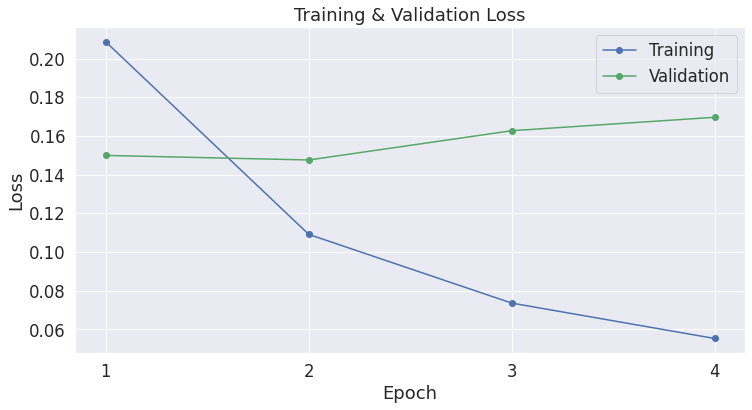

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()